# CC61: Procesamiento de Imágenes
# **Trabajo Final**

Alumnos:
* Galván Díaz, Joaquín Adrían : u201810A.
* Moreno Carhuacusma, Dante Brandon : u201818067

## Objetivos

* Distinguir una partitura musical en una imagen
* Extraer el sonido que correspone a los símbolos en la partitura
* Determinar el mejor acercamiento con técnicas de procesamiento de imágenes al problema

## Desarrollo

### Importación de librerías

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from skimage import io
#from google.colab.patches import cv2_imshow

In [ ]:
#No da error en colab pero no funciona el import {simbolo de exclamcion} pip install scikits.audiolab

In [ ]:
#from scikits.audiolab import play

### Cargar Imágenes

In [3]:
repo = "https://raw.githubusercontent.com/Carhuacusma/CC61_PDI_Trabajo_Final/main/Data/"

In [2]:
repo = "Data/"

In [3]:
ruta = "Fotos/mary_hoja.jpg"
imHoja = io.imread("%s%s"%(repo,ruta))
print(type(imHoja))

<class 'imageio.core.util.Array'>


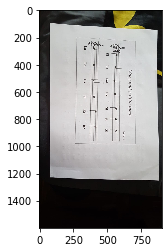

In [7]:
plt.imshow(imHoja)

In [4]:
ruta = "Ideal/mary_had_a_little_lamb.jpg"
imIdeal = io.imread("%s%s"%(repo,ruta))
print(type(imIdeal))

<class 'imageio.core.util.Array'>


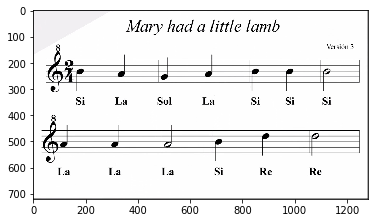

In [9]:
plt.imshow(imIdeal)

### Preprocesamiento

In [5]:
def ordenarEsquinas(pts):
    rect = np.zeros((4, 2), dtype = "float32") # Rectángulo de 0s para ser como un canvas
    oAux = pts.sum(axis = 1) # Arreglo de 4 resultados...................................... : oAux[i] = pts[i][0] + pts[i][1]
    rect[0] = pts[np.argmin(oAux)] # La esquina superior izquierda tiene la suma más pequeña
    rect[2] = pts[np.argmax(oAux)] # La esquina inferior derecha tiene la mayor suma
    oAux = np.diff(pts, axis = 1)  # ....................................................... : oAux[i] = |(pts[i][0] - pts[i][1])|
    rect[1] = pts[np.argmin(oAux)] # La esquina superior derecha minima diferencia (X mayor)
    rect[3] = pts[np.argmax(oAux)] # La esquina inferior izquierda maxima diferencia
    return rect

In [6]:
def warping(imagen, topL, topR, botR, botL):
    widthA = np.sqrt(((botR[0] - botL[0]) ** 2) + ((botR[1] - botL[1]) ** 2)) #.... | Distancia euclidiana
    widthB = np.sqrt(((topR[0] - topL[0]) ** 2) + ((topR[1] - topL[1]) ** 2)) #.... | ""
    heightA = np.sqrt(((topR[0] - botR[0]) ** 2) + ((topR[1] - botR[1]) ** 2)) #... | ""
    heightB = np.sqrt(((topL[0] - botL[0]) ** 2) + ((topL[1] - botL[1]) ** 2)) #... | ""
    maxWidth = max(int(widthA), int(widthB)) #......... | El anchos máximo se usa para la nueva imagen
    maxHeight = max(int(heightA), int(heightB)) #...... | El alto máximo se usa para la nueva imagen
    #.................................................. | dst: Puntos de destino, imagen "recta"
    dst = np.array([[0, 0],
                    [maxWidth - 1, 0],
                    [maxWidth - 1, maxHeight - 1],
                    [0, maxHeight - 1]], dtype = "float32")
    M = cv2.getPerspectiveTransform(np.array([topL,topR,botR,botL]), dst) #......... Matriz de transformación
    return cv2.warpPerspective(imagen, M, (maxWidth, maxHeight)) #.................. Aplicar la matriz para obtener la imagen nueva

In [7]:
def enCasoHoja(imagen,contornos,umbralHoja = 0.5):
    contornos = contornos[:int(0.15*len(contornos))] #........ 1. Extrae el 15 % de contornos con mayor área
    candHoja = []
    auxArea = 0
    for c in contornos: #..................................... 2. Por cada C que pertenece a Contornos:
        perimetro = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.015 * perimetro, True) #......2.1. Disminuir el número de lados de C (Polígono Aproximado)
        if len(approx) == 4: #.......................................2.2. Si el polígono aproximado es de 4 lados:
            auxArea = cv2.contourArea(approx) #................................ Considera el Área del "candidato a hoja"
            if auxArea/((imagen.shape[0])*(imagen.shape[1])) > umbralHoja: #... Si la proporción de las áreas candidato/imagen supera el umbral:
                candHoja = approx #................................................... "Candidato" es la hoja impresa
                break
    if len(candHoja) == 0:
        print("Imagen ideal")
        return imagen
    else:
        puntos = candHoja.reshape(4, 2) #... Para manejar mejor los puntos
        rect = ordenarEsquinas(puntos) #.... Ordena las esquinas a formato:
        (tl, tr, br, bl) = rect #........... Sentido Horario, Esquinas: Superior Izquierda, Superior Derecha,...
        print("Foto con esquinas")
        return warping(imagen,topL=tl,topR=tr,botR=br,botL=bl)

In [104]:
def hacerDFdeLineas(lineas):
    if lineas is None:
        print("No hay líneas")
        return None
    def valores(p1,p2):
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        theta = np.pi / 2
        if dx != 0:
            theta = np.arctan(dy/dx)
        theta = round(theta*100) / 100
        tam = pow((dx ** 2) + (dy ** 2), 0.5)
        tam = round(tam*10)/10
        sp1 = p1[0] + p1[1]
        sp2 = p2[0] + p2[1]
        if sp2 > sp1:
            return [p2,p1,tam,theta]
        return [p1,p2,tam,theta]
    dfLineas = []
    for linea in lineas:
        l = linea[0] #Acceder a los valores porque linea = [[x1 y1 x2 y2]]
        dfLineas.append(valores([l[0],l[1]], [l[2],l[3]]))
    return pd.DataFrame(data=dfLineas,columns=["Punto 1", "Punto 2", "Longitud", "Angulo"])

In [9]:
def rectificar(imagen, umbralHoja = 0.5):
    if len(imagen.shape) != 2:
        imagen = cv2.cvtColor(imagen,cv2.COLOR_RGB2GRAY) #....................| 1. Asegura Escala de Grises, 
    imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30) # .| 2. Blur, 
    im_canny = cv2.Canny(imagen,50,205) #...................................| 3. Edge Detector: Canny >> Imagen con bordes
    #............. Extraer la hoja impresa de la foto:
    contornos, _ = cv2.findContours(im_canny,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #...| 1. Extrae "Contornos" con Cadena (findContours) 
    contornos = sorted(contornos, key = cv2.contourArea, reverse = True) #..............| 2. Ordenar "Contornos" por Área
    imagen = enCasoHoja(im_canny,contornos,umbralHoja) #................................| 3. Imagen de la hoja impresa 
    #............. Rectificar la orientación
    # TODO: Hough de Líneas,
    # -> Flip x° para que el pentagrama encaje  
    return imagen

In [10]:
r_imHoja = rectificar(imHoja,0.5)

Foto con esquinas


In [105]:
linesP = cv2.HoughLinesP(r_imHoja, 1, np.pi / 180, 50, None, 50, 10)
dfLineas = hacerDFdeLineas(linesP)

In [106]:
dfLineas.head()

,Punto 1,Punto 2,Longitud,Angulo
0,"[305, 547]","[308, 341]",206.0,-1.56
1,"[340, 856]","[353, 113]",743.1,-1.55
2,"[296, 370]","[300, 114]",256.0,-1.56
3,"[188, 528]","[190, 376]",152.0,-1.56
4,"[289, 857]","[298, 328]",529.1,-1.55


In [107]:
dfPorLongitud = dfLineas.sort_values(by='Longitud')

In [108]:
dfPorLongitud = pd.DataFrame(data=dfPorLongitud.values,columns=["Punto 1","Punto 2","Longitud","Angulo"])
dfPorLongitud.head()

,Punto 1,Punto 2,Longitud,Angulo
0,"[328, 857]","[326, 807]",50,1.53
1,"[794, 802]","[794, 752]",50,1.57
2,"[306, 563]","[307, 513]",50,-1.55
3,"[575, 457]","[577, 406]",51,-1.53
4,"[290, 825]","[287, 774]",51.1,1.51


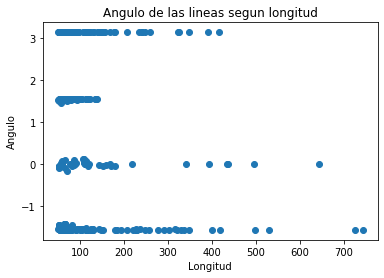

In [89]:
x_aux = dfPorLongitud["Longitud"]
y_aux = dfPorLongitud["Angulo"]
#plt.plot(x_aux, y_aux, 'o', label = "Plox")
plt.plot(x_aux, y_aux, 'o')
plt.xlabel('Longitud')
plt.ylabel('Angulo')
plt.title('Angulo de las lineas segun longitud')
#plt.legend()
plt.show()

(array([210.,  40.,  16.,   8.,   7.,   5.,   3.,   0.,   1.,   2.]),
 array([50.0, 119.3113719426576, 188.6227438853152, 257.9341158279728,
        327.2454877706304, 396.556859713288, 465.8682316559456,
        535.1796035986032, 604.4909755412608, 673.8023474839184,
        743.113719426576], dtype=object),
 <a list of 10 Patch objects>)

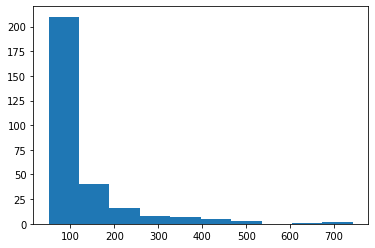

In [78]:
plt.hist(x_aux)

(array([106.,   0.,   1.,  43.,   0.,   0.,  57.,   0.,   0.,  85.]),
 array([-1.5619470002786389, -1.0915930348917957, -0.6212390695049523,
        -0.15088510411810896, 0.3194688612687342, 0.7898228266555773,
        1.260176792042421, 1.730530757429264, 2.2008847228161073,
        2.671238688202951, 3.141592653589793], dtype=object),
 <a list of 10 Patch objects>)

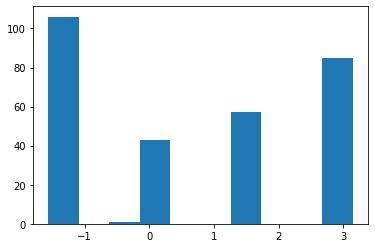

In [79]:
plt.hist(y_aux)

In [93]:
def BinningFreq(arr,n): #Se asume recibe matriz de dos dimensiones (Componente i de una imagen) 
    piv = len(arr)//n
    arrPiv = []
    for i in range(1,n):
        arrPiv.append(i*piv)
    arrPiv.append(len(arr))
    arreglo = []
    bins_aux = []
    previo = 0
    for piv in arrPiv:
        bins_aux = arr[previo:piv]
        arreglo.append(bins_aux)
        previo = piv
    return arreglo

In [ ]:
#def graficarTest(variableValores,nombreVar,errorSuma,errorCant,titulo):
#  plt.plot(variableValores, errorSuma, label = "Error en suma")
#  plt.plot(variableValores, errorCant, label = "Error en número de monedas")
#  plt.xlabel(nombreVar)
#  plt.ylabel('Error')
#  plt.title(titulo)
#  plt.legend()
#  plt.show()

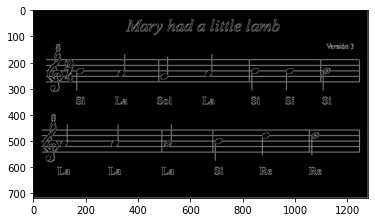

In [ ]:
plt.imshow(r_imIdeal,cmap='gray')

In [27]:
moda = stats.mode(slopes) #slopes ya no existe, pero es lass pendientesssss
print(moda)

ModeResult(mode=array([-1.]), count=array([85]))


In [90]:
auxIm = r_imHoja.copy()
auxIm = cv2.cvtColor(auxIm,cv2.COLOR_GRAY2BGR)
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(auxIm,(l[0],l[1]),(l[2],l[3]),(0,0,255),3)

In [92]:
while True:
    cv2.imshow("Guardar Color",auxIm)
    if cv2.waitKey(1) & 0xFF == ord('r'):
        break
cv2.destroyAllWindows()

In [24]:
ojio = pd.DataFrame(data=[['Juan',2001,'Peter'], ['Melissa',1985,'Peter'], ['Kim',1990,'Vaughn'], ['Rei',2005,'NaN']],columns=auxC)

In [35]:
ojio['Nombre']

0       Juan
1    Melissa
2        Kim
3        Rei
Name: Nombre, dtype: object

In [ ]:
cv2_imshow(auxIm[113:840,286:301])

In [ ]:
#https://docs.opencv.org/master/d4/d86/group__imgproc__filter.html#ga9d7064d478c95d60003cf839430737ed 
#https://docs.opencv.org/master/d4/d13/tutorial_py_filtering.html
#sigmaSpace alto podría terminar borrando detalles y no queremos eso porque líneas
#d=3 porque tampoco queremos un blur tan fuerte
imagen = cv2.bilateralFilter(imagen,d=3,sigmaColor=75,sigmaSpace=30)